In [57]:
!pip install torchattacks

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchattacks


In [58]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 64

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

classes = [str(i) for i in range(10)]


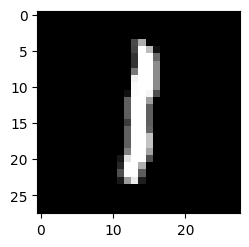

<ipython-input-59-10602fa1c99a>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, batch_size, i + 1)  # 1 row, `batch_size` columns, i+1 denotes the position of the subplot


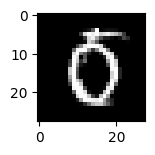

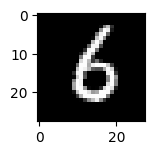

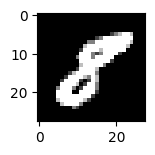

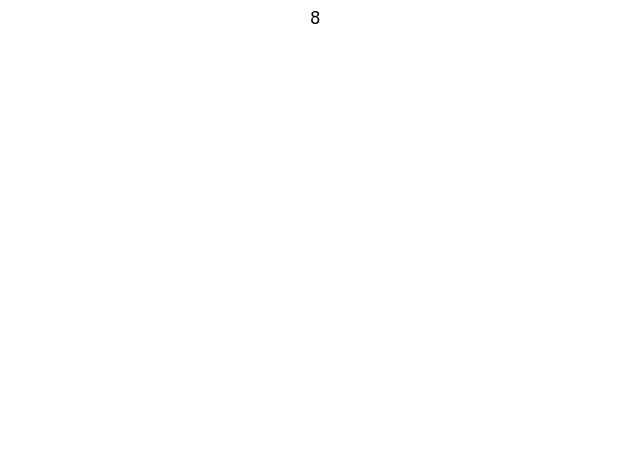

In [59]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

batch_size = 4  # Define the batch size

# Define the figure size
plt.figure(figsize=(3 * batch_size, 4))

# Show images and print labels for the first `batch_size` images
for i in range(batch_size):
    plt.subplot(1, batch_size, i + 1)  # 1 row, `batch_size` columns, i+1 denotes the position of the subplot
    imshow(images[i])
    plt.title(f"{classes[labels[i]]}")
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()


In [60]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x

model = SimpleCNN()


In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [62]:
num_epochs = 12
for epoch in range(num_epochs): # loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader: # get the inputs; images.to(device), labels.to(device) is a list of [images, labels]
        images, labels = images.to(device), labels.to(device)  # Move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val

    # Print training and validation statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
torch.save(model.state_dict(), 'mnist_model.pth')


In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Show images
plt.figure(figsize=(3, 3))  # 3 columns and 4 rows

for i in range(min(4, len(labels))):
    plt.subplot(2, 2, i + 1)  # 2 rows, 2 columns, i+1 denotes the position of the subplot
    imshow(images[i])
    plt.title(f"Label: {classes[labels[i]]}")
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

model.load_state_dict(torch.load('mnist_model.pth'))

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total:.2f} %')


In [ ]:
import torchattacks

# Initialize the FGSM Attack
attack_fgsm = torchattacks.FGSM(model, eps=8/255)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_fgsm(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)

# Calculate the success rate
success_rate = successful_attacks / total_samples


# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(original_image.squeeze(), cmap='gray')
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(adv_image.squeeze(), cmap='gray')
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torchattacks

# Initialize the FFGSM Attack
attack_ffgsm = torchattacks.FFGSM(model, eps=8/255)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_ffgsm(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)

# Calculate the success rate
success_rate = successful_attacks / total_samples


# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(original_image.squeeze(), cmap='gray')
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(adv_image.squeeze(), cmap='gray')
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torchattacks

# Initialize the RFGSM Attack
attack_rfgsm = torchattacks.RFGSM(model, eps=8/255)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_rfgsm(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)

# Calculate the success rate
success_rate = successful_attacks / total_samples


# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(original_image.squeeze(), cmap='gray')
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(adv_image.squeeze(), cmap='gray')
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torchattacks

# Initialize the EOTPGD Attack
attack_eotpgd = torchattacks.EOTPGD(model, eps=8/255)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_eotpgd(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)

# Calculate the success rate
success_rate = successful_attacks / total_samples


# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(original_image.squeeze(), cmap='gray')
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(adv_image.squeeze(), cmap='gray')
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torchattacks

# Initialize the CW Attack
attack_cw = torchattacks.CW(model)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_cw(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)

# Calculate the success rate
success_rate = successful_attacks / total_samples


# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(original_image.squeeze(), cmap='gray')
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(adv_image.squeeze(), cmap='gray')
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torchattacks

# Initialize the PGDL2 Attack
attack_pgdl2 = torchattacks.PGDL2(model)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_pgdl2(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)

# Calculate the success rate
success_rate = successful_attacks / total_samples


# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(original_image.squeeze(), cmap='gray')
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(adv_image.squeeze(), cmap='gray')
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()
